# Overfitting and Underfitting
Kaggle exercise for deep learning course.

tutorial: https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting/tutorial

In [2]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

spotify.head()



,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


### Define grooup split
 "grouped" split to keep all of an aritst's songs in one
 split or the other. This is to help prevent signal leakage 

 #### asked ChatGPT about group split: 
 - group_split is used for splitting data into training and testing sets, but with a special consideration for grouping. This is often useful in scenarios where there's a risk of data leakage across groups.
 - purpose: to ensure that all data points belonging to the same group (e.g., songs from the same artist) are either in the training set or the testing set, but not both. This helps prevent potential data leakage issues that could arise if information from the same group is present in both the training and testing sets.
 - why are same group kept together either the training set or the testing set?
 This is particularly useful in scenarios where you want to avoid potential information leakage across groups. 
 For example, if you're working with a dataset where each group represents a specific artist and you want to train a model to recognize patterns within each artist's work, it makes sense to keep all songs from a particular artist either in the training set or the testing set. This way, the model is evaluated on unseen data (songs from artists it hasn't been trained on), providing a more realistic assessment of its generalization performance. 
 The goal is to simulate a real-world scenario where the model needs to perform well on new, unseen instances of each group. By keeping all instances of a group together, the model is less likely to inadvertently learn patterns specific to that group during training, which could result in overly optimistic performance during testing.









In [3]:
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100 

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


### Train a linear model 
Starting with the simplest network, a linear model. 
This model has low capacity. 

Minimum Validation Loss: 0.1917


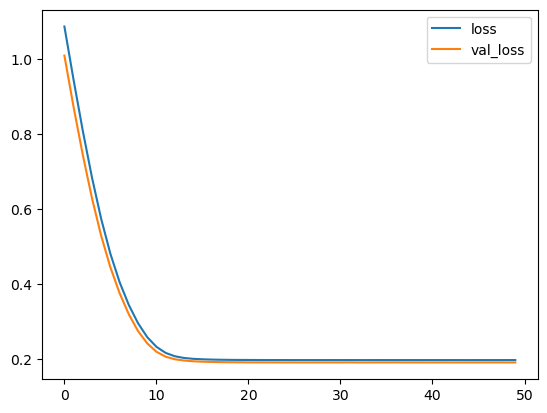

In [4]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size = 512,
    epochs = 50,
    verbose = 0,  # Suppress output since I will plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Since this hockey stick shape is hard to see, I changed epoch to 10 instead

Minimum Validation Loss: 0.1917


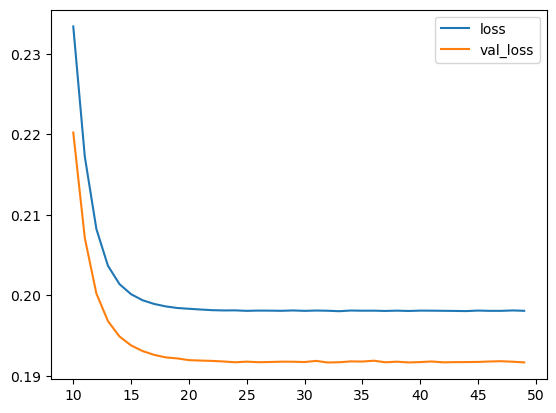

In [5]:
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

The gap between these curves is quite small and the validation loss never increases, so it's more likley that the network is underfitting than overfitting. It would be worth experimenting with more capacity to wee if that's the case. 

In the next code, I am adding some capacity to the network: add three layers with 128 units each. 

Epoch 1/50
48/48 [==============================] - 2s 16ms/step - loss: 0.2429 - val_loss: 0.2029
Epoch 2/50
48/48 [==============================] - 0s 5ms/step - loss: 0.2028 - val_loss: 0.1972
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1979 - val_loss: 0.1951
Epoch 4/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1953 - val_loss: 0.1929
Epoch 5/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1930 - val_loss: 0.1919
Epoch 6/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1917 - val_loss: 0.1924
Epoch 7/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1903 - val_loss: 0.1921
Epoch 8/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1889 - val_loss: 0.1908
Epoch 9/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1883 - val_loss: 0.1915
Epoch 10/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1875 - val_loss: 0.1905
Epoch 11/50
48/48 

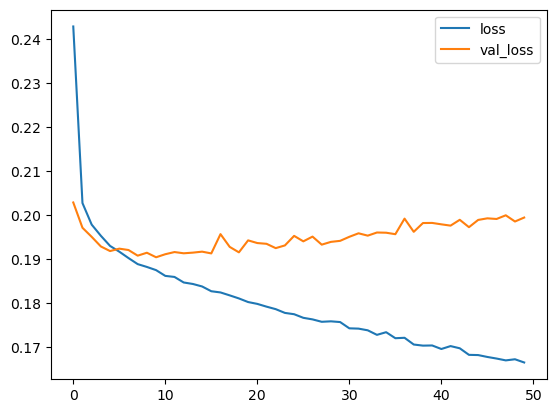

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping.

### Define Early Stopping Callback
- waits 5 epochs: `patience`
- change in validation loss: at least 0.001: `min_delta`
- keeps the weights with the best loss: `restore_best_weights`

In [11]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

### Train the model depending on the observation above

Epoch 1/50
48/48 [==============================] - 1s 11ms/step - loss: 0.2575 - val_loss: 0.2053
Epoch 2/50
48/48 [==============================] - 0s 5ms/step - loss: 0.2043 - val_loss: 0.1981
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1989 - val_loss: 0.1948
Epoch 4/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1956 - val_loss: 0.1929
Epoch 5/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1937 - val_loss: 0.1918
Epoch 6/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1917 - val_loss: 0.1915
Epoch 7/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1904 - val_loss: 0.1913
Epoch 8/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1892 - val_loss: 0.1908
Epoch 9/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1878 - val_loss: 0.1908
Epoch 10/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1870 - val_loss: 0.1921
Minimum Validation

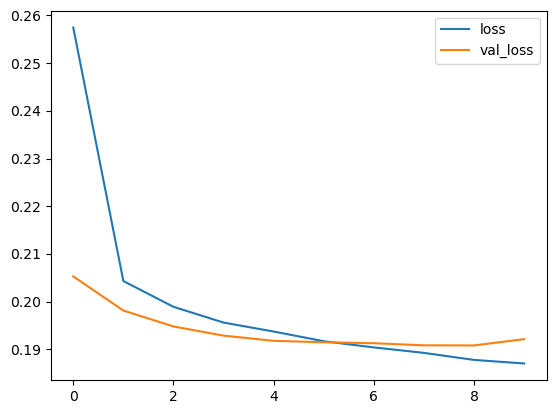

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
print("Minimum Validation loss: {0.4f}.format(history_df['val_loss']).min()")